In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.utils import shuffle as util_shuffle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

from torchdiffeq import odeint

from src.basis_functions import OrthonormalBasis, OrthonormalLegendre1D, BSpline1D, Fourier1D, OrthonormalHermite1D
from src.velocity_functions import Func, FuncTT
from src.ode_wrapper import ContinuousNormalizingFlowODE

from utils.trajectories import plot_trajectories_over_time, plot_vector_fields_at_times
from utils.gaussian import gaussian_density

#### Implementation incorporating FFJORD and RNODE approach

In [8]:
# Generate 2D sample data from Gaussian
def generate_data(mean, cov, n_samples):
    # Create a multivariate normal distribution and sample
    x = torch.distributions.MultivariateNormal(mean, cov).sample((n_samples,))
    return x

In [9]:
# Generate 2D sample data from GMM
def sample_gmm(weights, components, n_samples):
    component_indices = torch.multinomial(weights, n_samples, replacement=True)
    samples = []
    for i in range(n_samples):
        component = components[component_indices[i]]
        samples.append(component.sample())
    return torch.stack(samples)

In [10]:
# Generate 2D sample data from toy distributions
def inf_train_gen(data, rng=None, n_samples=1024):
    if rng is None:
        rng = np.random.RandomState()

    if data == "swissroll":
        data = sklearn.datasets.make_swiss_roll(n_samples=n_samples, noise=1.0)[0]
        data = torch.tensor(data, dtype=torch.float32)[:, [0, 2]]
        data /= 5
        return data

    elif data == "circles":
        data = sklearn.datasets.make_circles(n_samples=n_samples, factor=.5, noise=0.08)[0]
        data = torch.tensor(data, dtype=torch.float32)
        data *= 3
        return data

    elif data == "rings":
        n_samples4 = n_samples3 = n_samples2 = n_samples // 4
        n_samples1 = n_samples - n_samples4 - n_samples3 - n_samples2

        linspace4 = np.linspace(0, 2 * np.pi, n_samples4, endpoint=False)
        linspace3 = np.linspace(0, 2 * np.pi, n_samples3, endpoint=False)
        linspace2 = np.linspace(0, 2 * np.pi, n_samples2, endpoint=False)
        linspace1 = np.linspace(0, 2 * np.pi, n_samples1, endpoint=False)

        circ4_x = np.cos(linspace4)
        circ4_y = np.sin(linspace4)
        circ3_x = np.cos(linspace3) * 0.75
        circ3_y = np.sin(linspace3) * 0.75
        circ2_x = np.cos(linspace2) * 0.5
        circ2_y = np.sin(linspace2) * 0.5
        circ1_x = np.cos(linspace1) * 0.25
        circ1_y = np.sin(linspace1) * 0.25

        X = np.vstack([
            np.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
            np.hstack([circ4_y, circ3_y, circ2_y, circ1_y])
        ]).T * 3.0
        X = util_shuffle(X, random_state=rng)
        X = X + rng.normal(scale=0.08, size=X.shape)

        return torch.tensor(X, dtype=torch.float32)

    elif data == "moons":
        data = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.1)[0]
        data = torch.tensor(data, dtype=torch.float32)
        data = data * 2 + torch.tensor([-1, -0.2], dtype=torch.float32)
        return data

    elif data == "8gaussians":
        scale = 4.0
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), 
                   (1 / np.sqrt(2), 1 / np.sqrt(2)), 
                   (1 / np.sqrt(2), -1 / np.sqrt(2)), 
                   (-1 / np.sqrt(2), 1 / np.sqrt(2)), 
                   (-1 / np.sqrt(2), -1 / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(n_samples):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return torch.tensor(dataset, dtype=torch.float32)

    elif data == "pinwheel":
        radial_std = 0.3
        tangential_std = 0.1
        num_classes = 5
        num_per_class = n_samples // 5
        rate = 0.25
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

        features = rng.randn(num_classes * num_per_class, 2) * np.array([radial_std, tangential_std])
        features[:, 0] += 1.0
        labels = np.repeat(np.arange(num_classes), num_per_class)

        angles = rads[labels] + rate * np.exp(features[:, 0])
        rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
        rotations = np.reshape(rotations.T, (-1, 2, 2))

        X = 2 * rng.permutation(np.einsum("ti,tij->tj", features, rotations))
        return torch.tensor(X, dtype=torch.float32)

    elif data == "2spirals":
        n = np.sqrt(np.random.rand(n_samples // 2, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(n_samples // 2, 1) * 0.5
        d1y = np.sin(n) * n + np.random.rand(n_samples // 2, 1) * 0.5
        x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
        x += np.random.randn(*x.shape) * 0.1
        return torch.tensor(x, dtype=torch.float32)

    elif data == "checkerboard":
        x1 = np.random.rand(n_samples) * 4 - 2
        x2_ = np.random.rand(n_samples) - np.random.randint(0, 2, n_samples) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        return torch.tensor(np.concatenate([x1[:, None], x2[:, None]], 1) * 2, dtype=torch.float32)

    elif data == "line":
        x = rng.rand(n_samples) * 5 - 2.5
        y = x
        return torch.tensor(np.stack((x, y), 1), dtype=torch.float32)

    elif data == "cos":
        x = rng.rand(n_samples) * 5 - 2.5
        y = np.sin(x) * 2.5
        return torch.tensor(np.stack((x, y), 1), dtype=torch.float32)

    else:
        return inf_train_gen("8gaussians", rng, n_samples)


In [11]:
# Sample from the GMM with 2 modes
# weights = torch.tensor([0.25, 0.25, 0.25, 0.25,])
weights = torch.tensor([0.5, 0.5])
mean1 = torch.tensor([-2.0, -2.0])  
mean2 = torch.tensor([2.0, 2.0])
# mean3 = torch.tensor([-2.0, 2.0])  
# mean4 = torch.tensor([2.0, -2.0])  

component1 = torch.distributions.MultivariateNormal(mean1, 0.1 * torch.eye(2)) 
component2 = torch.distributions.MultivariateNormal(mean2, 0.1 * torch.eye(2)) 
# component3 = torch.distributions.MultivariateNormal(mean3, 0.1 * torch.eye(2))
# component4 = torch.distributions.MultivariateNormal(mean4, 0.1 * torch.eye(2))

# components = [component1, component2, component3, component4]
components = [component1, component2]

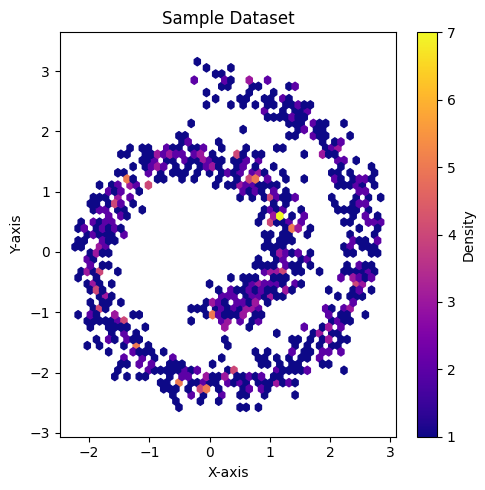

In [12]:
# Training parameters
n_samples = 1024
n_epochs = 25
batch_size = 64
learning_rate = 1e-3

# data = sample_gmm(weights, components, n_samples)
data = inf_train_gen("swissroll", rng=None, n_samples=n_samples)

plt.figure(figsize=(5, 5))

# Create a plot for the dataset
plt.hexbin(data[:, 0], data[:, 1], gridsize=50, cmap="plasma", mincnt=1)
plt.colorbar(label='Density')
plt.title(f"Sample Dataset")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis('equal')
    
plt.tight_layout()
plt.show()

In [13]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 16
d = 3

bases = [
        OrthonormalLegendre1D(dimension, domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 16


In [14]:
# Configure a Fourier basis for the FTT on the right-hand side of the ODE
# dimension = 8
# d = 3

# bases = [
#         Fourier1D(n=dimension, domain=(-5., 5.), normalize=True, period=5)
#         for _ in range(d)
#         ]
# print(f"Dimension: {bases[0].dimension}")

In [15]:
# # Configure a Hermite basis for the FTT on the right-hand side of the ODE
# dimension = 6
# d = 3

# bases = [
#         OrthonormalHermite1D(dimension)
#         for _ in range(d)
#         ]
# print(f"Dimension: {bases[0].dimension}")

Text(0.5, 1.0, 'Basis Functions 1D')

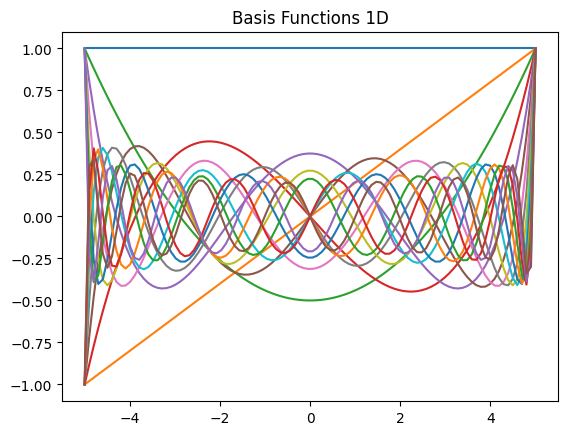

In [16]:
x = np.linspace(-5., 5., 100)
y = [bases[0](torch.tensor([x[i]])).squeeze(0) for i in range(100)]
plt.plot(x, y)
plt.title("Basis Functions 1D")

In [17]:
# TT-parametrized ODE system for density estimation inspired by the continuous normalizing flow formulation in Chen et al. 2018,
# regularized as in Finlay et al. 2020
class ContinuousNormalizingFlowODEDensityEstimation(nn.Module):
    def __init__(self, func, **kwargs):
        super().__init__(**kwargs)
        self.func = func # Function defining the velocity field driving the flow
        self.transport_cost = None
        self.trace_integral = None
        self.gradnorm_integral = None

    # Incorporated instantaneous change of variables formula
    def forward(self, t: float, state: torch.Tensor) -> torch.Tensor:
        """
        Compute the derivatives dx/dt, dz/dt, and dl/dt for the ODE system.
        This includes:
        - dx/dt = func(t, x)
        - dz/dt = ||func(t, x)||_2^2 (kinetic energy)
        - dl/dt = tr(Jacobian(func(t, x))) (log det of the Jacobian)
        - dg/dt = ||Jacobian(func(t, x))||_2^2 (integral of the Frobenius norm of the Jacobian)
        """
        x = state[:-3]  # Extract x(t) from the state
        z = state[-3]   # Extract z(t) from the state
        l = state[-2]   # Extract l(t) from the state
        g = state[-1]   # Extract g(t) from the state
        dxdt = self.func(t, x)
        dzdt = torch.norm(dxdt, p=2) ** 2
        
        def func_wrt_x(x):
            return self.func(t, x)
        
        jacobian = torch.autograd.functional.jacobian(func_wrt_x, x, create_graph=True, strict=False)
        trace_jacobian = torch.trace(jacobian)
        dldt = trace_jacobian
        norm_jacobian = torch.norm(jacobian, p="fro") ** 2
        dgdt = norm_jacobian
        return torch.cat([dxdt, dzdt.unsqueeze(0), dldt.unsqueeze(0), dgdt.unsqueeze(0)], dim=0)

    def solve_ode(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE for a given initial condition and time steps."""
        # Appended the initial transport cost (z(0) = 0) to the state
        y0_with_z_l_and_g = torch.cat([y0, torch.tensor([0.], dtype=y0.dtype), torch.tensor([0.], dtype=y0.dtype), torch.tensor([0.], dtype=y0.dtype)], dim=0)
        solution = odeint(self.forward, y0_with_z_l_and_g, ts, rtol=rtol, atol=atol, method=method)
        return solution

    def evaluate_final_state(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE and return the final state, transport cost, trace integral and gradient norm integral."""
        solution = self.solve_ode(y0, ts, rtol, atol, method)
        # Extract the final state, transport cost, trace integral, and gradient norm integral
        final_state = solution[-1, :-3]
        transport_cost = solution[-1, -3]  
        trace_integral = solution[-1, -2]
        gradnorm_integral = solution[-1, -1]
        return final_state, transport_cost, trace_integral, gradnorm_integral

    # Solve ODE backward in time
    def solve_ode_backward(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE backward in time."""
        # Reverse the time vector for backward integration
        ts_backward = torch.flip(ts, dims=[0])
        # Solve the ODE starting from the final state y0 at ts[-1]
        solution = odeint(self.func, y0, ts_backward, rtol=rtol, atol=atol, method=method)
        return solution[-1, :]
        
    def __call__(self, y0: torch.Tensor, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                 rtol=1e-3, atol=1e-6, method='euler', backward=False) -> torch.Tensor:
        """Main method to solve the ODE for batches or single initial conditions."""
        if backward:  # Solve ODE backward in time
            if y0.ndim == 2:  # Handle batched initial conditions
                final_states = []
                for i in range(y0.shape[0]):
                    final_state = self.solve_ode_backward(y0[i], ts, rtol, atol, method)
                    final_states.append(final_state)
                return torch.stack(final_states)
            else:  # Handle single initial condition
                final_state = self.solve_ode_backward(y0, ts, rtol, atol, method)
                return final_state
        else:  # Solve ODE foward in time
            if y0.ndim == 2:  # Handle batched initial conditions
                final_states = []
                transport_costs = []
                trace_integrals = []
                gradnorm_integrals = []
                for i in range(y0.shape[0]):
                    final_state, transport_cost, trace_integral, gradnorm_integral = self.evaluate_final_state(y0[i], ts, rtol, atol, method)
                    final_states.append(final_state)
                    transport_costs.append(transport_cost)
                    trace_integrals.append(trace_integral)
                    gradnorm_integrals.append(gradnorm_integral)
                self.transport_cost = torch.stack(transport_costs)
                self.trace_integral = torch.stack(trace_integrals)
                self.gradnorm_integral = torch.stack(gradnorm_integrals)
                return torch.stack(final_states)
            else:  # Handle single initial condition
                final_state, transport_cost, trace_integral, gradnorm_integral = self.evaluate_final_state(y0, ts, rtol, atol, method)
                self.transport_cost = transport_cost
                self.trace_integral = trace_integral
                self.gradnorm_integral = gradnorm_integral
                return final_state

In [18]:
# TT-parametrized ODE system for density estimation inspired by the continuous normalizing flow formulation in Chen et al. 2018,
# implemented based on the FFJORD approach from Grathwohl et al. 2018, and regularized as in Finlay et al. 2020
class ContinuousNormalizingFlowODEDensityEstimationRNODE(nn.Module):
    def __init__(self, func, **kwargs):
        super().__init__(**kwargs)
        self.func = func # Function defining the velocity field driving the flow
        self.transport_cost = None
        self.trace_integral = None
        self.gradnorm_integral = None

    # Incorporated instantaneous change of variables formula
    def forward(self, t: float, state: torch.Tensor) -> torch.Tensor:
        """
        Compute the derivatives dx/dt, dz/dt, and dl/dt for the ODE system.
        This includes:
        - dx/dt = func(t, x)
        - dz/dt = ||func(t, x)||_2^2 (kinetic energy)
        - dl/dt = tr(Jacobian(func(t, x))) (log det of the Jacobian, trace estimated via Monte-Carlo)
        - dg/dt = ||Jacobian(func(t, x))||_2^2 (integral of the Frobenius norm of the Jacobian, norm estimated via Monte-Carlo)
        """
        x = state[:-3]  # Extract x(t) from the state
        z = state[-3]   # Extract z(t) from the state
        l = state[-2]   # Extract l(t) from the state
        g = state[-1]   # Extract g(t) from the state
        dxdt = self.func(t, x)
        dzdt = torch.norm(dxdt, p=2) ** 2
        
        def func_wrt_x(x):
            return self.func(t, x)
        
        # Monte-Carlo trace estimator
        num_samples = 1
        trace_estimates = []
        norm_estimates = []

        for _ in range(num_samples):
            eps = generate_data(torch.tensor([0., 0.]), torch.eye(2), 1).squeeze()
            vjp = torch.autograd.functional.vjp(func_wrt_x, x, v=eps, create_graph=True, strict=False)[1]
            trace_estimate = vjp @ eps
            norm_estimate = torch.dot(vjp, vjp)
            trace_estimates.append(trace_estimate)
            norm_estimates.append(norm_estimate)

        trace_jacobian_estimate = torch.stack(trace_estimates).mean()
        norm_jacobian_estimate = torch.stack(norm_estimates).mean()

        # eps = generate_data(torch.tensor([0., 0.]), torch.eye(2), 1).squeeze()
        # vjp = torch.autograd.functional.vjp(func_wrt_x, x, v=eps, create_graph=True, strict=False)[1]
        # trace_jacobian_estimate = vjp @ eps

        dldt = trace_jacobian_estimate
        # norm_jacobian_estimate = torch.dot(vjp, vjp)
        dgdt = norm_jacobian_estimate
        return torch.clip(torch.cat([dxdt, dzdt.unsqueeze(0), dldt.unsqueeze(0), dgdt.unsqueeze(0)], dim=0), min=-1e1, max=1e1)

    def solve_ode(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE for a given initial condition and time steps."""
        # Appended the initial transport cost (z(0) = 0) to the state
        y0_with_z_l_and_g = torch.cat([y0, torch.tensor([0.], dtype=y0.dtype), torch.tensor([0.], dtype=y0.dtype), torch.tensor([0.], dtype=y0.dtype)], dim=0)
        solution = odeint(self.forward, y0_with_z_l_and_g, ts, rtol=rtol, atol=atol, method=method)
        
        if torch.isnan(solution).any() or torch.isinf(solution).any():
            print("Warning: Instable velocity field")
        
        return solution

    def evaluate_final_state(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE and return the final state, transport cost, trace integral and gradient norm integral."""
        solution = self.solve_ode(y0, ts, rtol, atol, method)
        # Extract the final state, transport cost, trace integral, and gradient norm integral
        final_state = solution[-1, :-3]
        transport_cost = solution[-1, -3]  
        trace_integral = solution[-1, -2]
        gradnorm_integral = solution[-1, -1]
        return final_state, transport_cost, trace_integral, gradnorm_integral

    # Solve ODE backward in time
    def solve_ode_backward(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE backward in time."""
        # Reverse the time vector for backward integration
        ts_backward = torch.flip(ts, dims=[0])
        # Solve the ODE starting from the final state y0 at ts[-1]
        solution = odeint(self.func, y0, ts_backward, rtol=rtol, atol=atol, method=method)
        return solution[-1, :]
        
    def __call__(self, y0: torch.Tensor, ts: torch.Tensor = torch.tensor(np.linspace(0., 4., 16)), 
                 rtol=1e-3, atol=1e-6, method='rk4', backward=False) -> torch.Tensor:
        """Main method to solve the ODE for batches or single initial conditions."""
        if backward:  # Solve ODE backward in time
            if y0.ndim == 2:  # Handle batched initial conditions
                final_states = []
                for i in range(y0.shape[0]):
                    final_state = self.solve_ode_backward(y0[i], ts, rtol, atol, method)
                    final_states.append(final_state)
                return torch.stack(final_states)
            else:  # Handle single initial condition
                final_state = self.solve_ode_backward(y0, ts, rtol, atol, method)
                return final_state
        else:  # Solve ODE foward in time
            if y0.ndim == 2:  # Handle batched initial conditions
                final_states = []
                transport_costs = []
                trace_integrals = []
                gradnorm_integrals = []
                for i in range(y0.shape[0]):
                    final_state, transport_cost, trace_integral, gradnorm_integral = self.evaluate_final_state(y0[i], ts, rtol, atol, method)
                    final_states.append(final_state)
                    transport_costs.append(transport_cost)
                    trace_integrals.append(trace_integral)
                    gradnorm_integrals.append(gradnorm_integral)
                self.transport_cost = torch.stack(transport_costs)
                self.trace_integral = torch.stack(trace_integrals)
                self.gradnorm_integral = torch.stack(gradnorm_integrals)
                return torch.stack(final_states)
            else:  # Handle single initial condition
                final_state, transport_cost, trace_integral, gradnorm_integral = self.evaluate_final_state(y0, ts, rtol, atol, method)
                self.transport_cost = transport_cost
                self.trace_integral = trace_integral
                self.gradnorm_integral = gradnorm_integral
                return final_state

In [19]:
class ConcatFunc(nn.Module):
    def __init__(self, func_list: list, **kwargs):
        super().__init__(**kwargs)
        self.func_list = func_list
        self.num_funcs = len(func_list)
        self.t_domain_lower_bound = 0
        self.t_domain_upper_bound = len(func_list)
        
    def __call__(self, t: float, x: torch.Tensor):
        # Iterate over each function and its corresponding interval
        for i, func in enumerate(self.func_list):
            t_lower_bound = i
            t_upper_bound = i + 1

            # Check if all t values fall within the current interval
            if (t >= t_lower_bound and t < t_upper_bound) or (t == self.t_domain_upper_bound and t == t_upper_bound):
                return func(t - i, x)

        # If t does not fall within any interval, raise an error
        raise ValueError(f"t must be in the range [0, {self.t_domain_upper_bound}]")

In [20]:
class StackFunc(nn.Module):
    def __init__(self, func_list: list, **kwargs):
        super().__init__(**kwargs)
        self.func_list = func_list
        self.num_funcs = len(func_list)
        # Learnable parameters
        self.w = nn.Parameter(
            torch.randn(self.num_funcs).to(torch.float32) * 1e1 / 
            torch.sqrt(torch.tensor(self.num_funcs, dtype=torch.float32))
        )

    def __call__(self, t: float, x: torch.Tensor):
        # Iterate over each function and stack values into tensor
        func_list = []

        for func in self.func_list:
            func_list.append(func(t, x))
            
        func_values = torch.stack(func_list, dim=0)

        return self.w.T @ func_values

In [21]:
func = Func(d_in=2, d_out=2, bases=bases, time_dependent=True)

In [22]:
ftt_rank4_1 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank4_2 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank4_3 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank4_4 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank4_5 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank4_6 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank4_7 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank4_8 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
# ftt_rank4_9 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
# ftt_rank4_10 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
# ftt_rank4_11 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
# ftt_rank4_12 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)

In [23]:
# Test
x = torch.tensor([1., 1.])
ftt_rank4_1(0., x)

tensor([ 0.2069, -0.2179], grad_fn=<SqueezeBackward1>)

In [24]:
func_list = [
    
    ftt_rank4_1
    , ftt_rank4_2
    , ftt_rank4_3
    , ftt_rank4_4
    # , ftt_rank4_5
    # , ftt_rank4_6
    # , ftt_rank4_7
    # , ftt_rank4_8
    # , ftt_rank4_9
    # , ftt_rank4_10
    # , ftt_rank4_11
    # , ftt_rank4_12

    ]

In [25]:
x = torch.tensor([1., 1.])

In [26]:
concat_func = ConcatFunc(func_list)
concat_func(0, x)

tensor([ 0.2069, -0.2179], grad_fn=<SqueezeBackward1>)

In [27]:
stack_func = StackFunc(func_list)
stack_func(0, x)

/var/folders/rc/9s_11zv502jcx5bnwgh4bmr00000gn/T/ipykernel_80468/4037665541.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  return self.w.T @ func_values


tensor([-1.4777,  2.7013], grad_fn=<SqueezeBackward4>)

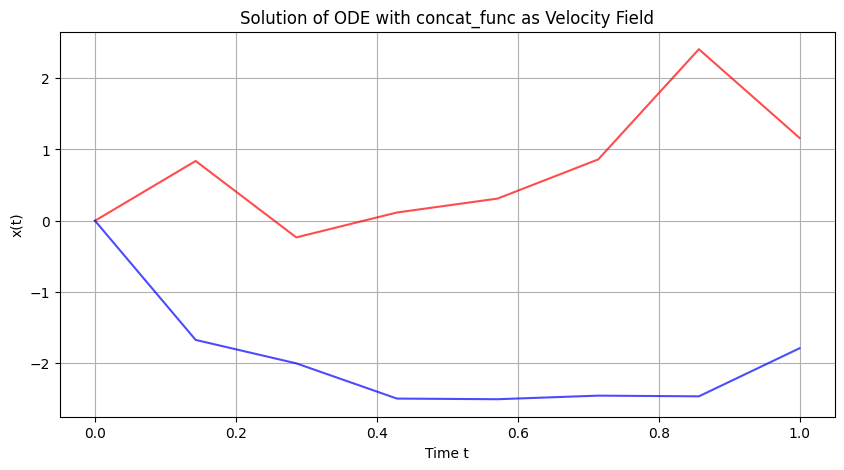

In [29]:
# Define batched initial conditions: x0 has shape (batch_size, d)
x0 = torch.tensor([[0., 0.]], dtype=torch.float32)
# x0 = torch.tensor([[0., 0.], [1., 1.], [-1., -1.], [2., 2.], [-2., -2.]], dtype=torch.float32)
# x0 = generate_data(torch.tensor([0., 0.]), torch.eye(2), 100)

# Time points at which to solve the ODE
t = torch.linspace(0., 1., 8)  # 12 time points from 0 to 6

# Solve the ODE using odeint for batched data
# solution = odeint(concat_func, x0, t, method='euler')
solution = odeint(stack_func, x0, t, method='euler')

# Extract the solution for plotting
x_values = solution.detach().numpy()  # Convert to NumPy for plotting
t_values = t.numpy()  # Convert time points to NumPy

# Plot the solution for each initial condition in the batch
plt.figure(figsize=(10, 5))

for i in range(len(x0)):
    plt.plot(t_values, x_values[:, i, 0], label=f'x1(t) for x0[{i}]', alpha=0.7, color='red')
    plt.plot(t_values, x_values[:, i, 1], label=f'x2(t) for x0[{i}]', alpha=0.7, color='blue')

plt.xlabel('Time t')
plt.ylabel('x(t)')
plt.title('Solution of ODE with concat_func as Velocity Field')
# plt.legend()
# plt.axis([0., 12., -5., 5.])
plt.grid(True)
plt.show()

In [30]:
# model_rank4_concat = ContinuousNormalizingFlowODEDensityEstimationRNODE(concat_func)
model_rank4_stack = ContinuousNormalizingFlowODEDensityEstimationRNODE(stack_func)

# Set the models to training mode and choose optimizer
# model_rank4_concat.train()
model_rank4_stack.train()

# Test
# x = torch.tensor([[0., 0.], [0.5, 0.5], [1., 1.]])
x = torch.tensor([0., 0.])
# y = model_rank4_concat(x)
y = model_rank4_stack(x)
y

tensor([13.1861,  0.6240], grad_fn=<SliceBackward0>)

In [31]:
# optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)

# Collect all parameters from func_list
params = []
for func in model_rank4_stack.func.func_list:
    params.extend(func.parameters())  # Add parameters from each FuncTT object

params.extend(model_rank4_stack.func.parameters())

# Now, create the optimizer with the collected parameters
optimizer_rank4_stack = optim.AdamW(params, lr=learning_rate)

# Norm of TT cores
sum(torch.norm(core, p='fro') for func in model_rank4_stack.func.func_list for core in func.tt_cores)

tensor(67.1352, dtype=torch.float64, grad_fn=<AddBackward0>)

In [32]:
# Loss function for sample-based density estimation
def loss_func(model, x: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg, lambda_grad_reg):
    
    y_pred = model(x, ts, rtol, atol, method, backward)
    
    l2_transport_cost = model.transport_cost
    log_det_gradient_func = model.trace_integral
    gradnorm_regularization = model.gradnorm_integral
    
    # tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)
    # tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.coefficient_tensor)
    tt_regularization = sum(torch.norm(core, p='fro') for func in model.func.func_list for core in func.tt_cores)
    p_y_pred = gaussian_density(y_pred, torch.eye(2), True)
    loss = - torch.log(torch.clip(p_y_pred, min=1e-8)) - log_det_gradient_func + lambda_transport_reg * l2_transport_cost + lambda_grad_reg * gradnorm_regularization

    return loss.mean() + lambda_tt_reg * tt_regularization

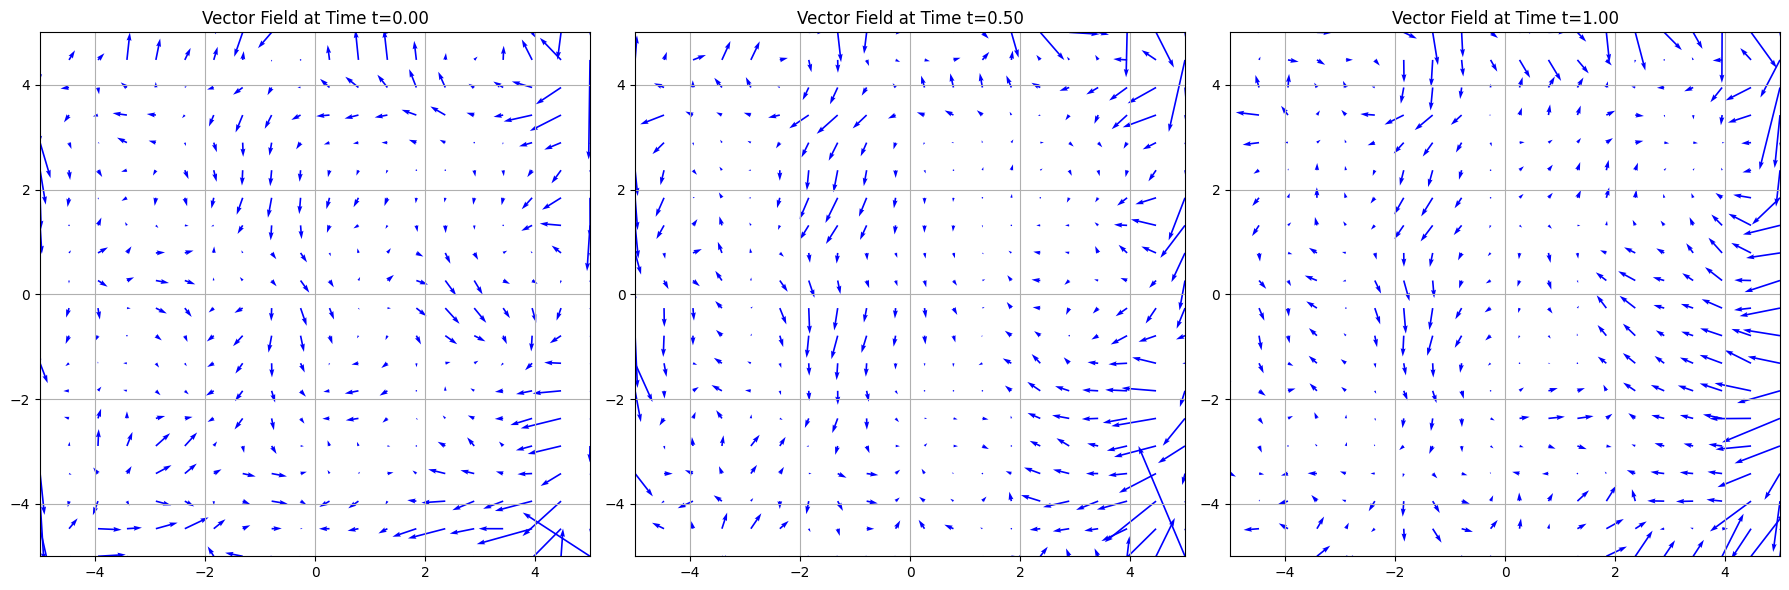

In [33]:
# Plot ODE flow vector field in various points in time before training
plot_vector_fields_at_times(model_rank4_stack.func, x_range = (-5., 5.), y_range = (-5., 5.), plot_time = torch.tensor([0.0, 0.5, 1.0]))

In [34]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-2, lambda_tt_reg = 1e-3, lambda_grad_reg = 1e-2):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Variable to track if learning rate had been reduced
    # reduced_lr = False
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0

        # Reduce lambda_tt_reg
        # lambda_transport_reg *= 1 / (10 ** (1/10))
        # lambda_tt_reg *= 1 / (10 ** (1/10))

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg, lambda_grad_reg)
            epoch_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            
            for func in model.func.func_list:
                torch.nn.utils.clip_grad_norm_(func.parameters(), max_norm=10.0)

            # Compute the norm of the gradient before the optimizer step
            # grad_norm = sum(torch.norm(core.grad, p='fro') for func in model.func.func_list for core in func.tt_cores)
            
            # Perform the optimizer step
            optimizer.step()
            
            norm_tt_cores = sum(torch.norm(core, p='fro') for func in model.func.func_list for core in func.tt_cores)

            # print(f"TT Cores Norm: {norm_tt_cores:.4f}")
            # print(f"Trace Integral: {model.trace_integral.mean():.4f}")
            # print(f"Parameter Gradient Norm: {grad_norm:.4f}")

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)
        
        # Compute norm of TT cores after the epoche
        # norm_tt_cores = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)
        # norm_tt_cores = sum(torch.norm(core, p='fro') for func in model_rank4_concat.func.func_list for core in func.tt_cores)

        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Reduce learning rate to ensure convergence
        # if (epoch +1) % 10 == 0: # and not reduced_lr:
        #     lr = optimizer.param_groups[0]['lr'] * 1e-1 
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr  
        #         reduced_lr = True
        #     print(f"INFO: Reduced Learning Rate to {lr}")
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}, "
                  f"Gradient Norm: {model.gradnorm_integral.mean():.4f}, "
                  f"TT Cores Norm: {norm_tt_cores:.4f}"
            )
            
    training_dict[training_id] = loss_history

In [35]:
n_epochs = 10

In [40]:
training_dict = {}
# training_procedure(model_rank8, data, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8", ts = torch.tensor(np.linspace(0., 1., 8)))

training_procedure(model_rank4_stack, data, batch_size, n_epochs, optimizer_rank4_stack, training_dict, "Rank 4 Stack", ts = torch.tensor(np.linspace(0., 1., 8)))


Training Run ID: Rank 4 Stack



In [37]:
# Define batched initial conditions: x0 has shape (batch_size, d)

x0 = generate_data(torch.tensor([0., 0.]), torch.eye(2), 100)

# Time points at which to solve the ODE
t = torch.linspace(4., 0., 16)  # 12 time points from 0 to 6

# Solve the ODE using odeint for batched data
solution = odeint(stack_func, x0, t, method='euler')

# Extract the solution for plotting
x_values = solution.detach().numpy()  # Convert to NumPy for plotting
t_values = t.numpy()  # Convert time points to NumPy

# Plot the solution for each initial condition in the batch
plt.figure(figsize=(10, 5))
for i in range(100):
    plt.plot(t_values, x_values[:, i, 0], label=f'x1(t) for x0[{i}]', alpha=0.7, color='red')
    plt.plot(t_values, x_values[:, i, 1], label=f'x2(t) for x0[{i}]', alpha=0.7, color='blue')
plt.xlabel('Time t')
plt.ylabel('x(t)')
plt.title('Solution of ODE with concat_func as Velocity Field')
# plt.legend()
plt.grid(True)
plt.show()

RuntimeError: size mismatch, got input (8), mat (8x100), vec (4)

In [38]:
z_data = generate_data(torch.tensor([0., 0.]), torch.eye(2), 512)
z_pred = model_rank4_stack(z_data, ts=torch.linspace(0, 1, 8), rtol=0.001, atol=0.000001, method='euler', backward=True)

(np.float64(-7.5), np.float64(7.5), np.float64(-7.5), np.float64(7.5))

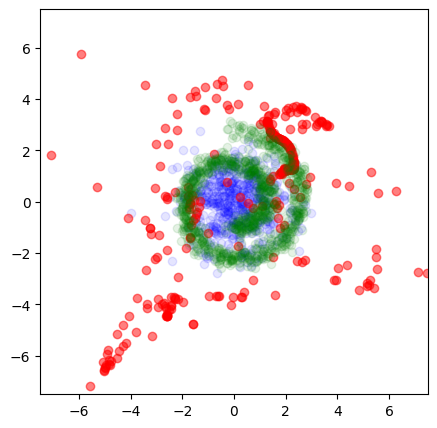

In [39]:
plt.figure(figsize=(5, 5))

plt.scatter(z_data[:, 0].detach().numpy(), z_data[:, 1].detach().numpy(), color='blue', alpha=0.1)
plt.scatter(z_pred[:, 0].detach().numpy(), z_pred[:, 1].detach().numpy(), color='red', alpha=0.5)
plt.scatter(data[:, 0].detach().numpy(), data[:, 1].detach().numpy(), color='green', alpha=0.1)

plt.axis([-7.5, 7.5, -7.5, 7.5])

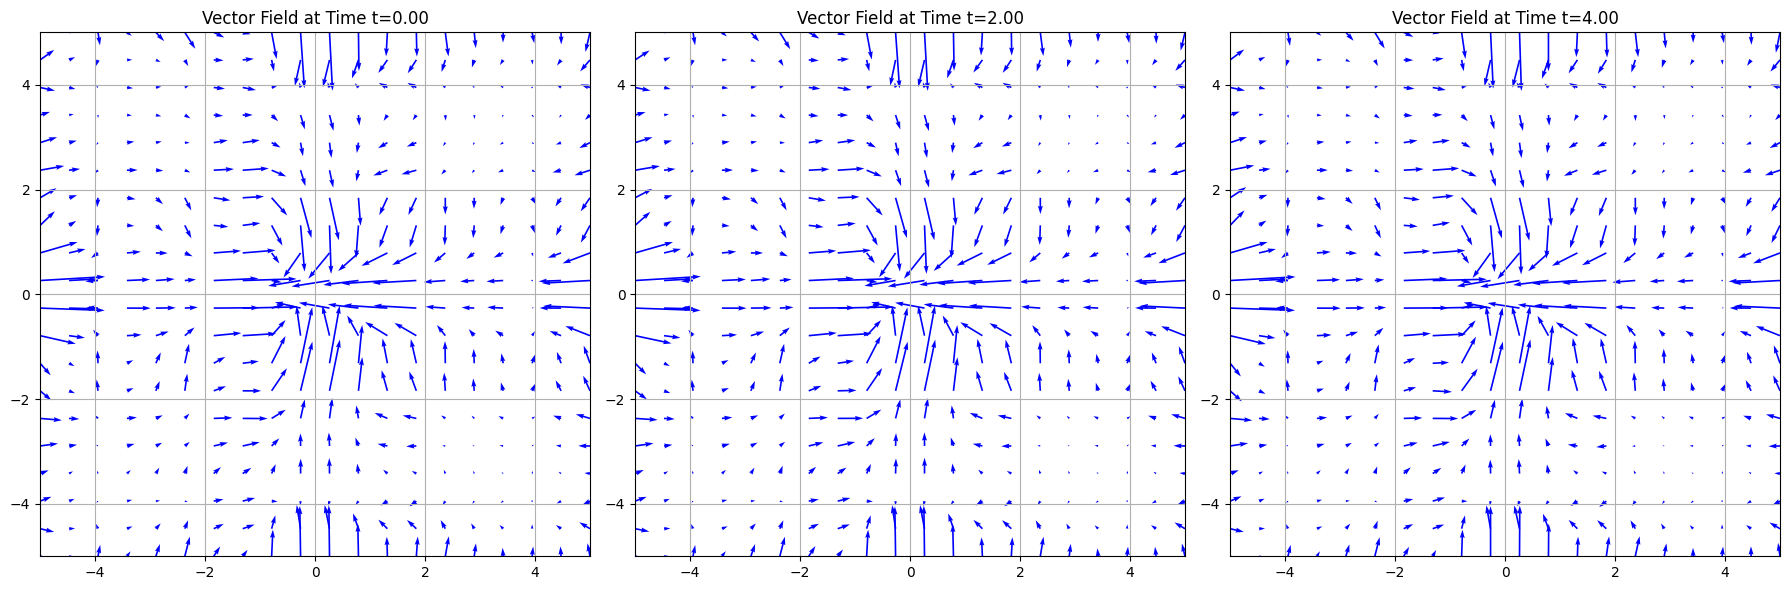

In [57]:
# Plot ODE flow vector field in various points in time after training
plot_vector_fields_at_times(model_rank4_stack.func, x_range = (-5., 5.), y_range = (-5., 5.), plot_time = torch.tensor([0.0, 2.0, 4.0]))

In [495]:
# Plot estimated probability density on 2D
def posterior_density(x):
    if x.dim() == 1:
        x = x.unsqueeze(0)

    def model_rank4_concat_wrt_x(x):
        return model_rank4_concat(x, ts=torch.linspace(0, 6, 24), rtol=0.001, atol=0.000001, method='euler', backward=False)

    # Compute the Jacobian for each element in the batch
    jacobians = []
    for x_i in x:
        jacobian = torch.autograd.functional.jacobian(model_rank4_concat_wrt_x, x_i, create_graph=False, strict=False)
        jacobians.append(jacobian)

    jacobian = torch.stack(jacobians)
    y_pred = model_rank4_concat(x, ts=torch.linspace(0, 6, 24), rtol=0.001, atol=0.000001, method='euler', backward=False)
    p_y_pred = gaussian_density(y_pred, torch.eye(2), True) * torch.det(jacobian)

    return p_y_pred


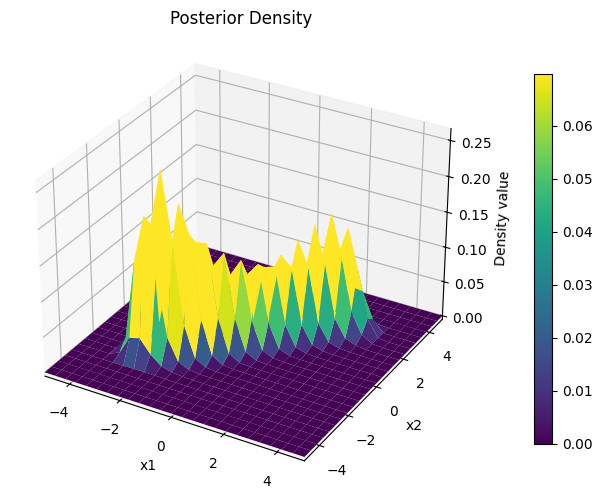

In [496]:
# Define the test data grid
n = 25
data_x_1 = torch.linspace(-5., 5., n)
data_x_2 = torch.linspace(-5., 5., n)
data = torch.cartesian_prod(data_x_1, data_x_2)

# Create a figure for the posterior density plot
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8, 6))

# Calculate the posterior density for the test data
posterior_values = posterior_density(data)
posterior_values_np = posterior_values.detach().numpy()

# Reshape the posterior density values into (n, n) grid form for surface plotting
X1, X2 = np.meshgrid(data_x_1.numpy(), data_x_2.numpy())
Z_posterior = posterior_values_np.reshape(n, n)

# Plot: Estimated Posterior Density
ax.set_title('Posterior Density', pad=2)
norm = mcolors.Normalize(vmin=np.min(Z_posterior), vmax=np.percentile(Z_posterior, 95))
surf = ax.plot_surface(X1, X2, Z_posterior, cmap='viridis', norm=norm)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Density value')
fig.colorbar(surf, ax=ax, shrink=0.8, pad=0.1)
ax.set_xlim([-5., 5.])
ax.set_ylim([-5., 5.])
# ax.set_zlim([0, np.max(Z_posterior) * 1.1])

# Show the plot
plt.show()

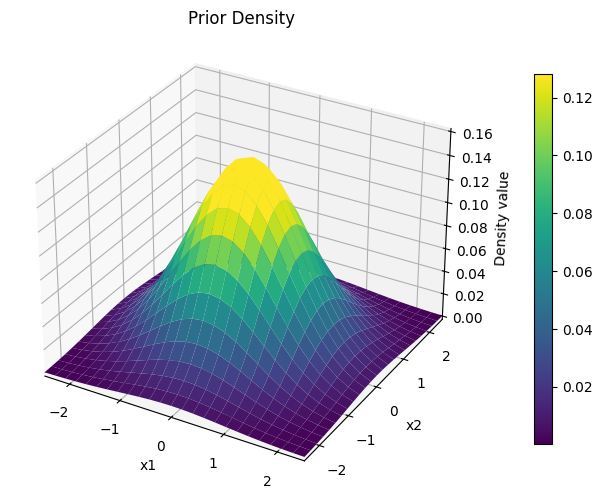

In [126]:
# Define the test data grid
n = 25
data_x_1 = torch.linspace(-2.5, 2.5, n)
data_x_2 = torch.linspace(-2.5, 2.5, n)
data = torch.cartesian_prod(data_x_1, data_x_2)

# Create a figure for the posterior density plot
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8, 6))

# Calculate the density for the data
density_values = gaussian_density(data, torch.eye(2), True)
density_values_np = density_values.detach().numpy()

# Reshape the posterior density values into (n, n) grid form for surface plotting
X1, X2 = np.meshgrid(data_x_1.numpy(), data_x_2.numpy())
Z_posterior = density_values_np.reshape(n, n)

# Plot: Density
ax.set_title('Prior Density', pad=2)
norm = mcolors.Normalize(vmin=np.min(Z_posterior), vmax=np.percentile(Z_posterior, 95))
surf = ax.plot_surface(X1, X2, Z_posterior, cmap='viridis', norm=norm)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Density value')
fig.colorbar(surf, ax=ax, shrink=0.8, pad=0.1)
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
# ax.set_zlim([0, np.max(Z_posterior) * 1.1])

# Show the plot
plt.show()

#### Implementation incorporating OT-Flow approach

In [17]:
class PotentialTT(nn.Module):
    def __init__(self, d_in: int, d_out: int, bases: list, tt_rank: int, matrix_rank: int, **kwargs):
        super().__init__(**kwargs)
        assert len(bases) == d_in + 1
        self.d_in = d_in
        self.d_out = d_out
        self.bases = bases
        self.matrix_rank = matrix_rank
        self.ranks = [1] + [tt_rank] * d_in + [d_out]
        self.dims = [basis.dimension for basis in bases]

        # Initialize all learnable parameters
        # TT cores
        self.size = np.sum(np.asarray(self.ranks[:-1]) * np.asarray(self.dims) * np.asarray(self.ranks[1:]))
        self.tt_cores = nn.ParameterList(
            [nn.Parameter(torch.randn(self.ranks[i], self.dims[i], self.ranks[i+1]).to(torch.float32) / torch.sqrt(torch.tensor(self.size, dtype=torch.float32)))
                for i in range(len(self.dims))
            ]
        )
        # Initialize further learnable parameters
        self.w = nn.Parameter(
            torch.randn(self.d_out).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.d_out, dtype=torch.float32))
        )
        self.A = nn.Parameter(
            torch.randn(self.matrix_rank, self.d_in + 1).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.matrix_rank * (self.d_in + 1), dtype=torch.float32))
        )
        self.b = nn.Parameter(
            torch.randn(self.d_in + 1).to(torch.float32) / 
            torch.sqrt(torch.tensor(self.d_in + 1, dtype=torch.float32))
        )
        self.c = nn.Parameter(
            torch.randn(1).to(torch.float32)
        )

    def eval_ftt(self, t: float, x: torch.Tensor):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [basis(input_with_time[:, i]) for i, basis in enumerate(self.bases)]

        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores[k].float(), bases_eval[k].float())

        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        
        return result
    
    def eval(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate quadratic potentials
        quadratic_term = torch.tensor(0.5) * input_with_time.T @ (self.A.T @ self.A) @ input_with_time + self.b.T @ input_with_time + self.c
        # Return potentials
        return self.w.T @ self.eval_ftt(t, x) + quadratic_term

    def partial_ftt(self, t: float, x: torch.Tensor, var_index: int):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [
            basis(input_with_time[:, i], m_derivative=1) if i == var_index else basis(input_with_time[:, i], m_derivative=0) 
            for i, basis in enumerate(self.bases)
        ]
        
        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores[k].float(), bases_eval[k].float())

        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        
        return result
    
    def grad_ftt(self, t: float, x: torch.Tensor):
        # Stack all partial derivatives w.r.t. variable x to obtain gradient
        partials = [self.partial_ftt(t, x, i) for i in range(1, x.shape[0] + 1, 1)]
        
        return torch.stack(partials, dim=0)
    
    def partial_t(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate linear dynamics
        linear_term = (self.A.T @ self.A) @ input_with_time + self.b
        # Return partial derivative w.r.t. variable t
        return self.partial_ftt(t, x, 0) @  self.w + linear_term[0]

    def grad(self, t: float, x: torch.Tensor):
        # Concatenate time with input
        input_with_time = torch.cat([torch.tensor([t]), x], dim=0)
        # Calculate linear dynamics
        linear_term = (self.A.T @ self.A) @ input_with_time + self.b
        # Return gradient
        return self.grad_ftt(t, x) @ self.w + linear_term[1:]
    
    def second_partial_ftt(self, t: float, x: torch.Tensor, var_index: tuple):
        # Check if input `x` has a batch dimension
        if x.ndim == 1:
            # If not batched, add a batch dimension (batch_size=1)
            x = x.unsqueeze(0)  # Shape becomes [1, d_in]

        batch_size = x.shape[0]  # Get the batch size
        result = torch.ones((batch_size, 1), dtype=torch.float64, device=x.device)  # Initialize result with batch dimension
        
        t_tensor = torch.full((batch_size, 1), t, dtype=torch.float32, device=x.device)
        input_with_time = torch.cat([t_tensor, x], dim=1)  # Concatenate time with input
        bases_eval = [
            # Logic to calculate first/second order derivatives of basis functions
            basis(input_with_time[:, i], m_derivative=2) if i in var_index and len(set(var_index)) == 1
            else basis(input_with_time[:, i], m_derivative=1) if i in var_index and len(set(var_index)) == 2
            else basis(input_with_time[:, i], m_derivative=0)
            for i, basis in enumerate(self.bases)
        ]
        
        # Perform successive contractions between each core and basis for all dimensions
        for k in range(len(bases_eval)):
            result = torch.einsum("bi,ijk,bj->bk", result.float(), self.tt_cores[k].float(), bases_eval[k].float())
        # If the input was not batched, return a 1D tensor (remove batch dimension)
        if batch_size == 1:
            return result.squeeze(0)
        return result
    
    def hessian_ftt(self, t: float, x: torch.Tensor):
        # Calculate Hessian of FTT
        second_partials = []
        for j in range(1, x.shape[0] + 1, 1):
            second_partials_i = torch.stack([self.second_partial_ftt(t, x, var_index=(i, j)) @ self.w for i in range(1, x.shape[0] + 1, 1)], dim=0)
            second_partials.append(second_partials_i)
        hessian_ftt = torch.stack(second_partials, dim=0)
        return hessian_ftt
    
    def hessian(self, t: float, x: torch.Tensor):
        # Calculate the Hessian of the potential
        const = self.A.T @ self.A
        return self.hessian_ftt(t, x) + const[1:,1:]
        

#### Testing

In [18]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 32
d = 3

bases = [
        OrthonormalLegendre1D(dimension, domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 32


In [65]:
potential = PotentialTT(d_in=2, d_out=2, bases=bases, tt_rank=4, matrix_rank=4)


In [134]:
potential.w
potential.A
potential.b
potential.c

Parameter containing:
tensor([1.5054], requires_grad=True)

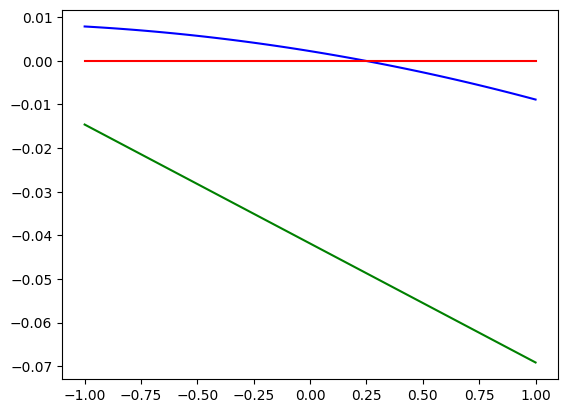

In [11]:
# x = torch.tensor([0.])
# potential.eval_ftt(0.5, x)

x = np.linspace(-1., 1., 100)
t = np.linspace(-1., 1., 100)
y = [potential.eval_ftt(torch.tensor(t[i]), torch.tensor([0.5])).detach().numpy() for i in range(100)]
z = [potential.partial_ftt(torch.tensor(t[i]), torch.tensor([0.5]), var_index=0).detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z, color='green')
plt.plot(x, np.zeros(100), color='red')

In [123]:
partial_1 = potential.partial_ftt(torch.tensor(0.5), torch.tensor([0.5, 0.5]), var_index=1)
partial_2 = potential.partial_ftt(torch.tensor(0.5), torch.tensor([0.5, 0.5]), var_index=2)

In [124]:
partial_1, partial_2

(tensor([0.0076, 0.0125], grad_fn=<SqueezeBackward1>),
 tensor([-0.0066,  0.0013], grad_fn=<SqueezeBackward1>))

In [131]:
linear = (potential.A.T @ potential.A) @ torch.tensor([0.5, 0.5, 0.5]) + potential.b
linear [1:]

tensor([0.6549, 0.0507], grad_fn=<SliceBackward0>)

In [132]:
potential.grad_ftt(torch.tensor(0.5), torch.tensor([0.5, 0.5])) @ potential.w + linear [1:]

tensor([0.6510, 0.0461], grad_fn=<AddBackward0>)

In [126]:
potential.grad(torch.tensor(0.5), torch.tensor([0.5, 0.5]))

tensor([0.6510, 0.0461], grad_fn=<AddBackward0>)

In [23]:
potential.second_partial_ftt(torch.tensor(0.5), torch.tensor([0.5]), (0, 0))

tensor([0.1567, 0.0169], grad_fn=<SqueezeBackward1>)

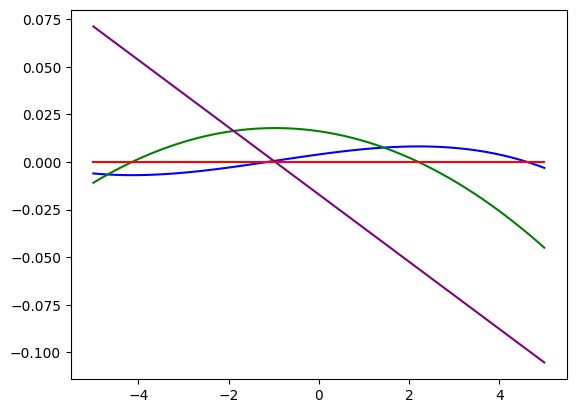

In [21]:
x = np.linspace(-5., 5., 100)
t = np.linspace(-5., 5., 100)
y = [potential.eval_ftt(torch.tensor(t[i]), torch.tensor([0.5])).detach().numpy() for i in range(100)]
z_1 = [potential.partial_ftt(torch.tensor(t[i]), torch.tensor([0.5]), var_index=0).detach().numpy() for i in range(100)]
z_2 = [potential.second_partial_ftt(torch.tensor(t[i]), torch.tensor([0.5]), var_index=(0,0)).detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z_1, color='green')
plt.plot(x, z_2, color='purple')
plt.plot(x, np.zeros(100), color='red')

In [204]:
potential = PotentialTT(d_in=2, d_out=2, bases=bases, tt_rank=4, matrix_rank=4)

In [205]:
t = torch.tensor(0.5)
x = torch.tensor([0.5, 0.5])

In [206]:
potential.second_partial_ftt(t, x, var_index=(2, 2)) @ potential.w

tensor(0.0013, grad_fn=<DotBackward0>)

In [207]:
const = potential.A.T @ potential.A
potential.hessian_ftt(t, x) + const[1:,1:]

tensor([[ 0.1280, -0.0790],
        [-0.0790,  0.6511]], grad_fn=<AddBackward0>)

In [208]:
potential.hessian(t, x) 

tensor([[ 0.1280, -0.0790],
        [-0.0790,  0.6511]], grad_fn=<AddBackward0>)

In [209]:
potential.eval(torch.tensor(0.5), torch.tensor([0.5, 0.5]))

tensor([0.2651], grad_fn=<AddBackward0>)

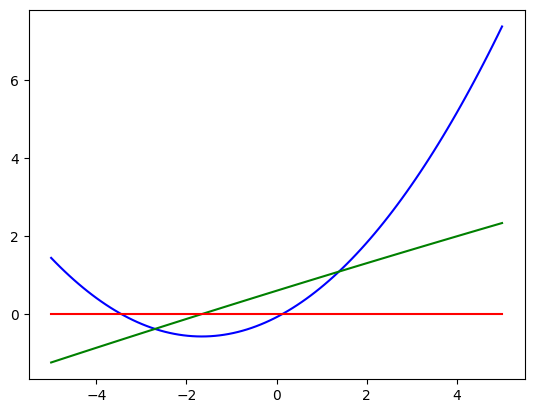

In [210]:
x = np.linspace(-5., 5., 100)
t = np.linspace(-5., 5., 100)
y = [potential.eval(torch.tensor(t[i], dtype=torch.float32), torch.tensor([0.5, 0.5])).detach().numpy() for i in range(100)]
z_1 = [potential.partial_t(torch.tensor(t[i], dtype=torch.float32), torch.tensor([0.5, 0.5])).detach().numpy() for i in range(100)]
# z_2 = [potential.second_partial_ftt(torch.tensor(t[i]), torch.tensor([0.5]), var_index=(0,0)).detach().numpy() for i in range(100)]
plt.plot(x, y, color='blue')
plt.plot(x, z_1, color='green')
# plt.plot(x, z_2, color='purple')
plt.plot(x, np.zeros(100), color='red')

In [19]:
# TT-parametrized ODE system for density estimation inspired by the continuous normalizing flow formulation in Chen et al. 2018,
# implemented based on the OT-Flow approach from Onken et al. 2021
class ContinuousNormalizingFlowODEDensityEstimationOTFlow(nn.Module):
    def __init__(self, potential, **kwargs):
        super().__init__(**kwargs)
        self.potential = potential # Function defining the potential driving the flow
        self.transport_cost = None
        self.trace_integral = None
        self.hjb_integral = None

    # Incorporated instantaneous change of variables formula
    def forward(self, t: float, state: torch.Tensor) -> torch.Tensor:
        """
        To be adapted: 
        Compute the derivatives dx/dt, dz/dt, and dl/dt for the ODE system.
        This includes:
        - dx/dt = func(t, x)
        - dz/dt = ||func(t, x)||_2^2 (kinetic energy)
        - dl/dt = tr(Jacobian(func(t, x))) (log det of the Jacobian, trace estimated via Monte-Carlo)
        - dg/dt = ||Jacobian(func(t, x))||_2^2 (integral of the Frobenius norm of the Jacobian, norm estimated via Monte-Carlo)
        """
        x = state[:-3]  # Extract x(t) from the state
        z = state[-3]   # Extract z(t) from the state
        l = state[-2]   # Extract l(t) from the state
        g = state[-1]   # Extract g(t) from the state
        dxdt = - self.potential.grad(t, x)
        dzdt = 0.5 * torch.norm(dxdt, p=2) ** 2

        dldt = - torch.trace(self.potential.hessian(t, x))
        drdt = torch.abs(self.potential.partial_t(t, x) - 0.5 * torch.norm(dxdt, p=2) ** 2)

        # def func_wrt_x(x):
        #     return self.func(t, x)
        
        # Monte-Carlo trace estimator
        # num_samples = 1
        # trace_estimates = []
        # norm_estimates = []

        # for _ in range(num_samples):
        #     eps = generate_data(torch.tensor([0., 0.]), torch.eye(2), 1).squeeze()
        #     vjp = torch.autograd.functional.vjp(func_wrt_x, x, v=eps, create_graph=True, strict=False)[1]
        #     trace_estimate = vjp @ eps
        #     norm_estimate = torch.dot(vjp, vjp)
        #     trace_estimates.append(trace_estimate)
        #     norm_estimates.append(norm_estimate)

        # trace_jacobian_estimate = torch.stack(trace_estimates).mean()
        # norm_jacobian_estimate = torch.stack(norm_estimates).mean()

        # eps = generate_data(torch.tensor([0., 0.]), torch.eye(2), 1).squeeze()
        # vjp = torch.autograd.functional.vjp(func_wrt_x, x, v=eps, create_graph=True, strict=False)[1]
        # trace_jacobian_estimate = vjp @ eps

        # dldt = trace_jacobian_estimate
        # norm_jacobian_estimate = torch.dot(vjp, vjp)
        # dgdt = norm_jacobian_estimate
        return torch.clip(torch.cat([dxdt, dzdt.unsqueeze(0), dldt.unsqueeze(0), drdt.unsqueeze(0)], dim=0), min=-1e1, max=1e1)

    def solve_ode(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE for a given initial condition and time steps."""
        # Appended the initial transport cost (z(0) = 0) to the state
        y0_with_z_l_and_r = torch.cat([y0, torch.tensor([0.], dtype=y0.dtype), torch.tensor([0.], dtype=y0.dtype), torch.tensor([0.], dtype=y0.dtype)], dim=0)
        solution = odeint(self.forward, y0_with_z_l_and_r, ts, rtol=rtol, atol=atol, method=method)
        
        if torch.isnan(solution).any() or torch.isinf(solution).any():
            print("Warning: Instable velocity field")
        
        return solution

    def evaluate_final_state(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE and return the final state, transport cost, trace integral and gradient norm integral."""
        solution = self.solve_ode(y0, ts, rtol, atol, method)
        # Extract the final state, transport cost, trace integral, and gradient norm integral
        final_state = solution[-1, :-3]
        transport_cost = solution[-1, -3]  
        trace_integral = solution[-1, -2]
        hjb_integral = solution[-1, -1]
        return final_state, transport_cost, trace_integral, hjb_integral

    # Solve ODE backward in time
    def solve_ode_backward(self, y0: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str) -> torch.Tensor:
        """Solve the ODE backward in time."""
        # Reverse the time vector for backward integration
        ts_backward = torch.flip(ts, dims=[0])
        # Solve the ODE starting from the final state y0 at ts[-1]
        def velocity_func(t, x):
            return - self.potential.grad(t, x)

        solution = odeint(velocity_func, y0, ts_backward, rtol=rtol, atol=atol, method=method)
        return solution[-1, :]
        
    def __call__(self, y0: torch.Tensor, ts: torch.Tensor = torch.tensor(np.linspace(0., 6., 24)), 
                 rtol=1e-3, atol=1e-6, method='rk4', backward=False) -> torch.Tensor:
        """Main method to solve the ODE for batches or single initial conditions."""
        if backward:  # Solve ODE backward in time
            if y0.ndim == 2:  # Handle batched initial conditions
                final_states = []
                for i in range(y0.shape[0]):
                    final_state = self.solve_ode_backward(y0[i], ts, rtol, atol, method)
                    final_states.append(final_state)
                return torch.stack(final_states)
            else:  # Handle single initial condition
                final_state = self.solve_ode_backward(y0, ts, rtol, atol, method)
                return final_state
        else:  # Solve ODE foward in time
            if y0.ndim == 2:  # Handle batched initial conditions
                final_states = []
                transport_costs = []
                trace_integrals = []
                hjb_integrals = []
                for i in range(y0.shape[0]):
                    final_state, transport_cost, trace_integral, hjb_integral = self.evaluate_final_state(y0[i], ts, rtol, atol, method)
                    final_states.append(final_state)
                    transport_costs.append(transport_cost)
                    trace_integrals.append(trace_integral)
                    hjb_integrals.append(hjb_integral)
                self.transport_cost = torch.stack(transport_costs)
                self.trace_integral = torch.stack(trace_integrals)
                self.hjb_integral = torch.stack(hjb_integrals)
                return torch.stack(final_states)
            else:  # Handle single initial condition
                final_state, transport_cost, trace_integral, hjb_integral = self.evaluate_final_state(y0, ts, rtol, atol, method)
                self.transport_cost = transport_cost
                self.trace_integral = trace_integral
                self.hjb_integral = hjb_integral
                return final_state

In [20]:
potential_rank4 = PotentialTT(d_in=2, d_out=16, bases=bases, tt_rank=16, matrix_rank=16)

model_rank4_ot_flow = ContinuousNormalizingFlowODEDensityEstimationOTFlow(potential_rank4)

# Set the models to training mode and choose optimizer
model_rank4_ot_flow.train()

# Test
x = torch.tensor([[0., 0.], [0.5, 0.5], [1., 1.]])
# x = torch.tensor([0., 0.])
y = model_rank4_ot_flow(x)
y

tensor([[-0.5120, -0.0767],
        [-0.5361, -2.8826],
        [-2.2880, -0.6222]], grad_fn=<StackBackward0>)

In [21]:
model_rank4_ot_flow.parameters

<bound method Module.parameters of ContinuousNormalizingFlowODEDensityEstimationOTFlow(
  (potential): PotentialTT(
    (tt_cores): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x32x16]
        (1): Parameter containing: [torch.float32 of size 16x32x16]
        (2): Parameter containing: [torch.float32 of size 16x32x16]
    )
  )
)>

In [22]:
# Now, create the optimizer with the parameters of the potential
optimizer_rank4_ot_flow = optim.AdamW(model_rank4_ot_flow.parameters(), lr=learning_rate)

# Norm of TT cores
sum(torch.norm(core, p='fro') for core in model_rank4_ot_flow.potential.tt_cores)

tensor(1.5692, grad_fn=<AddBackward0>)

In [23]:
# Loss function for sample-based density estimation
def loss_func(model, x: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg, lambda_hjb_reg):
    
    y_pred = model(x, ts, rtol, atol, method, backward)
    
    l2_transport_cost = model.transport_cost
    log_det_gradient_func = model.trace_integral
    hjb_regularization = model.hjb_integral
    
    tt_regularization = sum(torch.norm(core, p="fro") for core in model.potential.tt_cores)
    p_y_pred = gaussian_density(y_pred, torch.eye(2), True)
    loss = - torch.log(torch.clip(p_y_pred, min=1e-8)) - log_det_gradient_func + lambda_transport_reg * l2_transport_cost + lambda_hjb_reg * hjb_regularization
    
    return loss.mean() + lambda_tt_reg * tt_regularization

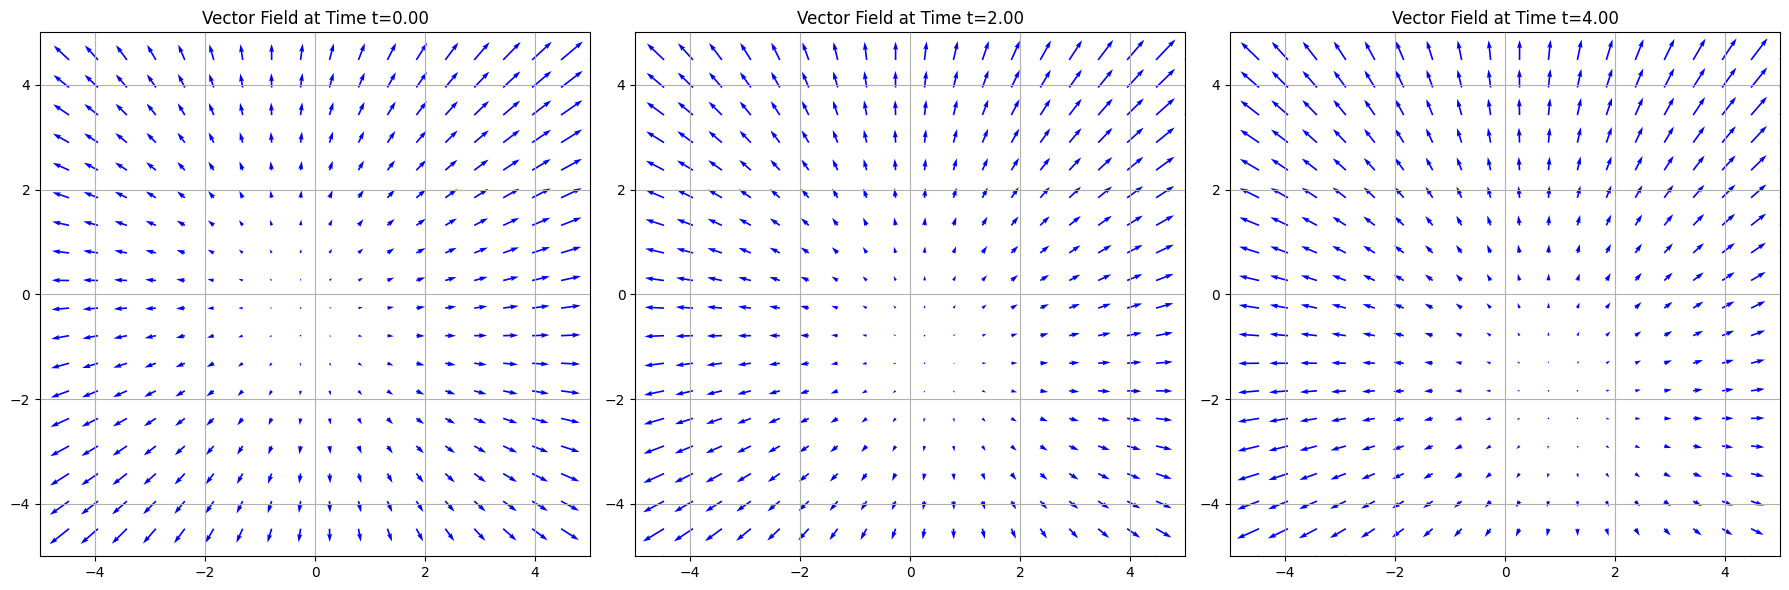

In [24]:
# Plot ODE flow vector field in various points in time before training
plot_vector_fields_at_times(model_rank4_ot_flow.potential.grad, x_range = (-5., 5.), y_range = (-5., 5.), plot_time = torch.tensor([0.0, 2.0, 4.0]))

In [25]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-2, lambda_tt_reg = 1e-3, lambda_hjb_reg = 1e-1):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Variable to track if learning rate had been reduced
    # reduced_lr = False
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0

        # Reduce lambda_tt_reg
        # lambda_transport_reg *= 1 / (10 ** (1/10))
        # lambda_tt_reg *= 1 / (10 ** (1/10))

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg, lambda_hjb_reg)
            epoch_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            
            # Perform the optimizer step
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)
        
        # Compute norm of TT cores after the epoche
        norm_tt_cores = sum(torch.norm(core, p="fro") for core in model.potential.tt_cores)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Reduce learning rate to ensure convergence
        # if (epoch +1) % 10 == 0: # and not reduced_lr:
        #     lr = optimizer.param_groups[0]['lr'] * 1e-1 
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr  
        #         reduced_lr = True
        #     print(f"INFO: Reduced Learning Rate to {lr}")
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}, "
                  f"HJB Regularizer: {model.hjb_integral.mean():.4f}, "
                  f"TT Cores Norm: {norm_tt_cores:.4f}"
            )
            
    training_dict[training_id] = loss_history

In [26]:
n_epochs = 10

In [27]:
training_dict = {}

training_procedure(model_rank4_ot_flow, data, batch_size, n_epochs, optimizer_rank4_ot_flow, training_dict, "Rank 4 OT flow", ts = torch.tensor(np.linspace(0., 1., 4)))


Training Run ID: Rank 4 OT flow

Epoch [1/10], Loss: 3.3918, Transport Cost: 0.2699, HJB Regularizer: 0.3519, TT Cores Norm: 1.9624
Epoch [2/10], Loss: 2.0131, Transport Cost: 0.3505, HJB Regularizer: 0.3593, TT Cores Norm: 2.7536
Epoch [3/10], Loss: 0.0095, Transport Cost: 0.3575, HJB Regularizer: 0.4183, TT Cores Norm: 3.2977
Epoch [4/10], Loss: -0.8170, Transport Cost: 0.5650, HJB Regularizer: 0.5383, TT Cores Norm: 3.6550
Epoch [5/10], Loss: -1.3839, Transport Cost: 0.7508, HJB Regularizer: 0.6337, TT Cores Norm: 3.8823
Epoch [6/10], Loss: -1.8652, Transport Cost: 0.7152, HJB Regularizer: 0.5899, TT Cores Norm: 4.0410
Epoch [7/10], Loss: -2.3762, Transport Cost: 0.6941, HJB Regularizer: 0.5462, TT Cores Norm: 4.1972
Epoch [8/10], Loss: -2.9126, Transport Cost: 0.8201, HJB Regularizer: 0.6905, TT Cores Norm: 4.4531
Epoch [9/10], Loss: -3.3045, Transport Cost: 0.8041, HJB Regularizer: 0.6241, TT Cores Norm: 4.6041
Epoch [10/10], Loss: -3.6840, Transport Cost: 1.0123, HJB Regularizer

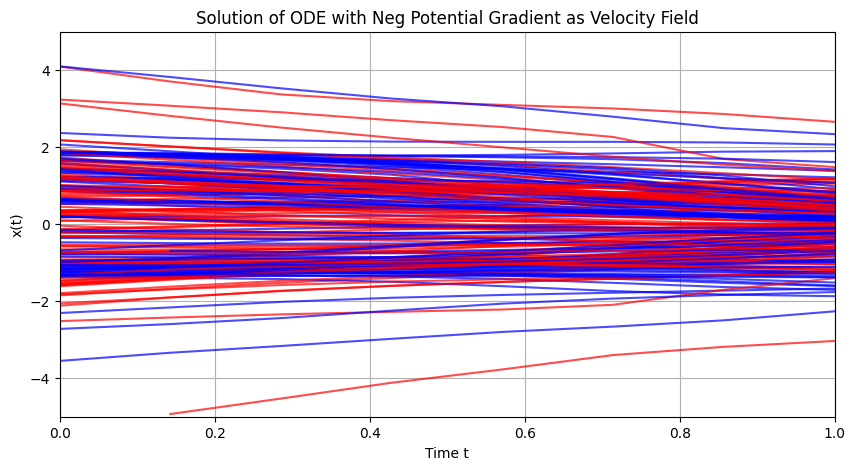

In [28]:
# Batched initial conditions
# x0 = torch.tensor([[0.5, 0.5], [-0.5, -0.5], [0.0, 0.0]])  # Example batch of 3 initial points
x0 = generate_data(torch.tensor([0., 0.]), torch.eye(2) * 0.8, 100)

# Time points at which to solve the ODE
t = torch.linspace(1., 0., 8)  # 96 time points from 1 to 0

# Define func
def func(t, x):
    # Ensure batched input for the function
    return -1 * torch.stack([potential_rank4.grad(t, xi) for xi in x], dim=0)

# Solve the ODE using odeint for batched data
solution = odeint(func, x0, t, method='rk4')

# Extract the solution for plotting
x_values = solution.detach().numpy()  # Convert to NumPy for plotting
t_values = t.numpy()  # Convert time points to NumPy

# Plot the solution for each initial condition in the batch
plt.figure(figsize=(10, 5))
for i in range(x0.shape[0]):  # Loop through each initial condition in the batch
    plt.plot(t_values, x_values[:, i, 0], label=f'x1(t) for x0[{i}]', alpha=0.7, color='red')
    plt.plot(t_values, x_values[:, i, 1], label=f'x2(t) for x0[{i}]', alpha=0.7, color='blue')
plt.xlabel('Time t')
plt.ylabel('x(t)')
plt.title('Solution of ODE with Neg Potential Gradient as Velocity Field')
plt.axis([0., 1., -5., 5.])
# plt.legend()
plt.grid(True)
plt.show()

In [29]:
z_data = generate_data(torch.tensor([0., 0.]), torch.eye(2) * 1, 512)
z_pred = model_rank4_ot_flow(z_data, ts=torch.linspace(0, 1, 8), rtol=0.001, atol=0.000001, method='euler', backward=True)

(np.float64(-7.5), np.float64(7.5), np.float64(-7.5), np.float64(7.5))

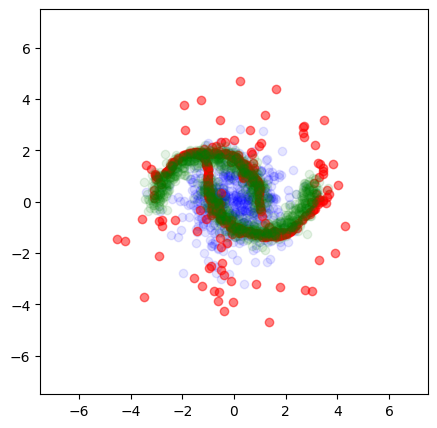

In [43]:
plt.figure(figsize=(5, 5))

plt.scatter(z_data[:, 0].detach().numpy(), z_data[:, 1].detach().numpy(), color='blue', alpha=0.1)
plt.scatter(z_pred[:, 0].detach().numpy(), z_pred[:, 1].detach().numpy(), color='red', alpha=0.5)
plt.scatter(data[:, 0].detach().numpy(), data[:, 1].detach().numpy(), color='green', alpha=0.1)
plt.axis([-7.5, 7.5, -7.5, 7.5])

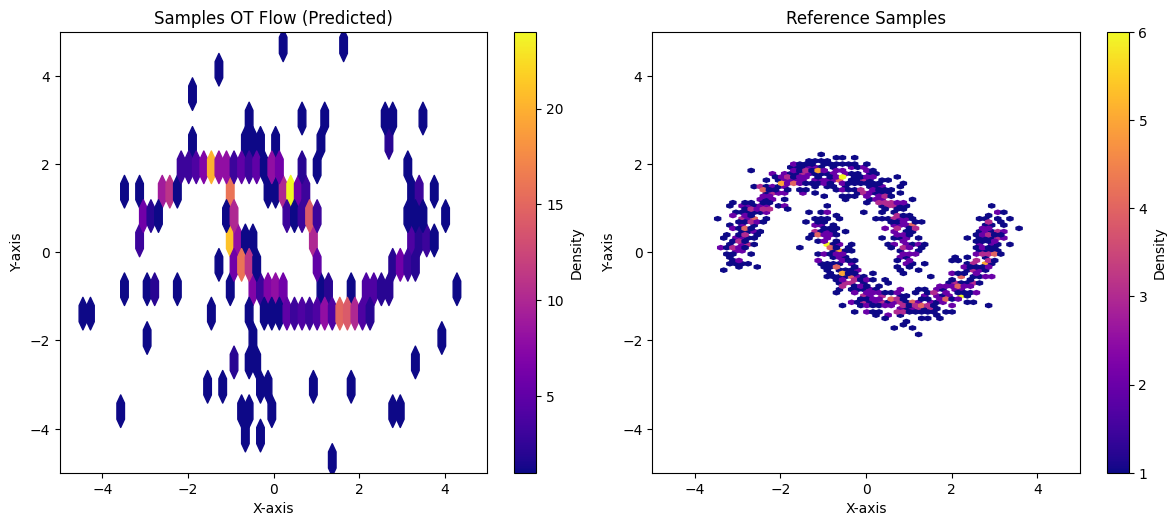

In [38]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.tight_layout()

# First hexbin plot
hb1 = axs[0].hexbin(z_pred[:, 0].detach().numpy(), z_pred[:, 1].detach().numpy(),
                    gridsize=50, cmap="plasma", mincnt=1)
cbar1 = fig.colorbar(hb1, ax=axs[0], label='Density')
axs[0].set_title("Samples OT Flow (Predicted)")
axs[0].set_xlabel("X-axis")
axs[0].set_ylabel("Y-axis")
axs[0].axis([-5, 5, -5, 5])

# Second hexbin plot
hb2 = axs[1].hexbin(data[:, 0].detach().numpy(), data[:, 1].detach().numpy(),
                    gridsize=50, cmap="plasma", mincnt=1)
cbar2 = fig.colorbar(hb2, ax=axs[1], label='Density')
axs[1].set_title("Reference Samples")
axs[1].set_xlabel("X-axis")
axs[1].set_ylabel("Y-axis")
axs[1].axis([-5, 5, -5, 5])

# Show plot
plt.show()
